In [67]:
#loading required packages
import re
import numpy as np
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
from better_profanity import profanity
import seaborn
import sklearn
from sklearn.metrics import precision_score,recall_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#reading the dataset
df = pd.read_csv('ebola_tweets.csv')

In [3]:
df.drop_duplicates(subset = ["timestamp", "user", "text"], inplace=True)
print(f"all tweets: {df.shape}")

all tweets: (8395, 6)


In [4]:
df.rename(columns={"text": "tweets"}, inplace=True)
df.head()

,timestamp,user,tweets,favorite_count,retweet_count,location
0,2023-01-06 20:52:04+00:00,NorbRomney,RT @nkcsteve55: @GovRonDeSantis Hmm...the Ebol...,0,0,NaN
1,2023-01-06 20:47:54+00:00,hernangraffe,RT @NIAIDNews: EBOLA NEWS: Three #Ebola #vacci...,0,12,Caracas
2,2023-01-06 20:47:19+00:00,mmd362230282,RT @WOAH: Our radio awareness campaign in the ...,0,38,NaN
3,2023-01-06 20:44:52+00:00,OscarSpivitz,@coopsimms @site_alpha To me it was like Ebola...,0,0,NaN
4,2023-01-06 20:42:28+00:00,mayrabella101,I am glad Liesel didn't do anything to Ebola ...,2,0,"New York, New York"


In [5]:
df['tweets'] = df['tweets'].str.replace("going", "lockdown")

In [6]:
# Converting only the tweets into a list
tweet_list = df.tweets.to_list()

In [7]:
# Creating a function to clean the tweets. Remove profanity, unnecessary characters, spaces, and stopwords.

def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    r = tweet.lower()
    r = profanity.censor(r)
    r = re.sub("'", "", r) # This is to avoid removing contractions in english
    r = re.sub("@[A-Za-z0-9_]+","", r)
    r = re.sub("#[A-Za-z0-9_]+","", r)
    r = re.sub(r'http\S+', '', r)
    r = re.sub('[()!?]', ' ', r)
    r = re.sub('\[.*?\]',' ', r)
    r = re.sub("[^a-z0-9]"," ", r)
    r = re.sub('rt','Mubende',r)
    r = r.split()
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from","us"]
    r = [w for w in r if not w in stopwords]
    r = " ".join(word for word in r)
    return r

In [8]:
#cleaning the data
cleaned = [clean_tweet(tw) for tw in tweet_list]
cleaned

['Mubende hmm ebola vaccine is mrna are you familiar with ebola might wanna check that out before trashing e',
 'Mubende ebola news three regimens shown be safe prompted immune responses adults children placebo co',
 'Mubende our radio awareness campaign democratic republic congo improved target population knowledge zoonoses by 45 usi',
 'me it was like ebola hydrogen bomb making baby but totally worse',
 'i am glad liesel didnt do anything ebola because i need her go toe toe with heather',
 'rebel attack congo ebola zone kills 18',
 'Mubende her book dark winter points inconsistencies guinea zoonosis narrative but both observa',
 'Mubende our radio awareness campaign democratic republic congo improved target population knowledge zoonoses by 45 usi',
 'Mubende 30 years vaccine experience he worked gates foundation s global health discovery team se',
 'imagine asking me what is pandemic i am nigeria bro i hav',
 'what world foreignpolicy',
 'global recession rising covid cases tsla sofi

In [9]:
# Defining the sentiment objects using TextBlob
sentiment_objects = [TextBlob(tweet) for tweet in cleaned]
sentiment_objects[0].polarity, sentiment_objects[0]

(0.375,
 TextBlob("Mubende hmm ebola vaccine is mrna are you familiar with ebola might wanna check that out before trashing e"))

In [10]:
# Creating a list of polarity values and tweet text
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]
sentiment_values[0]
sentiment_values[0:99]

[[0.375,
  'Mubende hmm ebola vaccine is mrna are you familiar with ebola might wanna check that out before trashing e'],
 [0.5,
  'Mubende ebola news three regimens shown be safe prompted immune responses adults children placebo co'],
 [0.0,
  'Mubende our radio awareness campaign democratic republic congo improved target population knowledge zoonoses by 45 usi'],
 [-0.4, 'me it was like ebola hydrogen bomb making baby but totally worse'],
 [0.5,
  'i am glad liesel didnt do anything ebola because i need her go toe toe with heather'],
 [0.0, 'rebel attack congo ebola zone kills 18'],
 [-0.125,
  'Mubende her book dark winter points inconsistencies guinea zoonosis narrative but both observa'],
 [0.0,
  'Mubende our radio awareness campaign democratic republic congo improved target population knowledge zoonoses by 45 usi'],
 [0.0,
  'Mubende 30 years vaccine experience he worked gates foundation s global health discovery team se'],
 [0.0, 'imagine asking me what is pandemic i am nigeria

In [11]:
# Creating a dataframe of each tweet against its polarity
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])
sentiment_df.head()

,polarity,tweet
0,0.375,Mubende hmm ebola vaccine is mrna are you fami...
1,0.500,Mubende ebola news three regimens shown be saf...
2,0.000,Mubende our radio awareness campaign democrati...
3,-0.400,me it was like ebola hydrogen bomb making baby...
4,0.500,i am glad liesel didnt do anything ebola becau...


In [12]:
sentiment_df['category'] = np.where(sentiment_df['polarity'] > 0, 'Positive', np.where(sentiment_df['polarity'] <0, 'Negative', 'Neutral'))

In [13]:
sentiment_df.head()

,polarity,tweet,category
0,0.375,Mubende hmm ebola vaccine is mrna are you fami...,Positive
1,0.500,Mubende ebola news three regimens shown be saf...,Positive
2,0.000,Mubende our radio awareness campaign democrati...,Neutral
3,-0.400,me it was like ebola hydrogen bomb making baby...,Negative
4,0.500,i am glad liesel didnt do anything ebola becau...,Positive


In [14]:
sentiment_df['category'].value_counts()

Neutral     3690
Positive    2820
Negative    1885
Name: category, dtype: int64

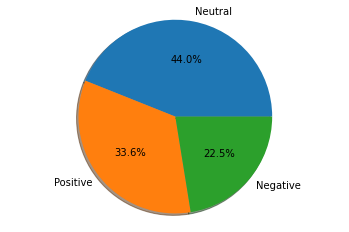

In [15]:
# Counting the number of occurrences of each category
counts = sentiment_df['category'].value_counts()

# Pie Chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.show()

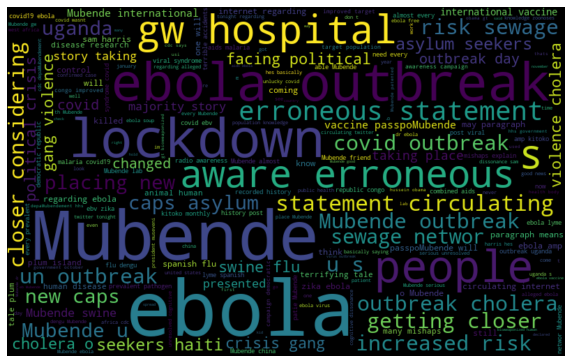

In [16]:
# Creating a Wordcloud from the tweets
from PIL import Image
all_words = ' '.join([text for text in cleaned])
wordcloud = WordCloud(width=800, height=500, random_state=21,  max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
#plt.show()
plt.savefig('cloudword.pdf')

In [18]:
#sentiment scores
mapping = {'Positive':0,'Negative':1,'Neutral':2}
sentiment_df['category'] = sentiment_df['category'].map(mapping)

In [58]:

# Prepare the data
#tweets = [
#    "I love this product!",
#    "This is a terrible product.",
#    "I am not sure about this product.",
#    "It is an average product."
#]

#sentiments = [1, 0, 2, 1] # 1: positive, 0: negative, 2: neutral

# Tokenizing the tweets
tokenizer = Tokenizer(num_words=100, oov_token="<OOV>")
tokenizer.fit_on_texts(sentiment_df['tweet'])

# Converting tweets to sequences
sequences = tokenizer.texts_to_sequences(sentiment_df['tweet'])

# Padding the sequences
padded_sequences = pad_sequences(sequences, padding='post', maxlen=None)

labels = sentiment_df['category']

# Splitting the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=0)

# Splitting the training set into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=0)

In [81]:
train_data.shape

(5372, 27)

In [100]:
train_data

array([[ 5, 55,  1, ...,  0,  0,  0],
       [ 2,  1,  1, ...,  0,  0,  0],
       [ 2, 79,  1, ...,  0,  0,  0],
       ...,
       [ 1,  7, 85, ...,  0,  0,  0],
       [37,  8,  1, ...,  0,  0,  0],
       [ 2, 55,  1, ...,  0,  0,  0]])

In [59]:
print(f"Size of the training data: {len(train_data)}")
print(f"Size of the training labels data: {len(train_labels)}")
print(f"Size of the validation data: {len(val_data)}")
print(f"Size of the validation lables data: {len(val_labels)}")
print(f"Size of the testing data: {len(test_data)}")
print(f"Size of the testing labels: {len(test_labels)}")

Size of the training data: 5372
Size of the training labels data: 5372
Size of the validation data: 1344
Size of the validation lables data: 1344
Size of the testing data: 1679
Size of the testing labels: 1679


In [59]:
gpus = tf.config.experimental.list_physical_devices('GPU')
len(gpus)

1

# CNN model

In [111]:
# Defining the model
model = keras.Sequential([
    keras.layers.Embedding(input_dim=5372, output_dim=16),
    keras.layers.Conv1D(filters=32, kernel_size=3,padding="valid", activation='relu'),
    keras.layers.GlobalMaxPooling1D(),
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(units=3, activation='softmax')
])

In [112]:

# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(train_data, train_labels, epochs=100,verbose=1,batch_size=64, validation_data=(val_data, val_labels))

Epoch 1/100
84/84 [==============================] - 3s 13ms/step - loss: 1.0345 - accuracy: 0.4587 - val_loss: 0.9850 - val_accuracy: 0.5171
Epoch 2/100
84/84 [==============================] - 1s 11ms/step - loss: 0.9040 - accuracy: 0.5923 - val_loss: 0.8473 - val_accuracy: 0.6042
Epoch 3/100
84/84 [==============================] - 1s 12ms/step - loss: 0.7938 - accuracy: 0.6385 - val_loss: 0.7759 - val_accuracy: 0.6644
Epoch 4/100
84/84 [==============================] - 1s 13ms/step - loss: 0.7305 - accuracy: 0.6746 - val_loss: 0.7348 - val_accuracy: 0.6778
Epoch 5/100
84/84 [==============================] - 1s 12ms/step - loss: 0.6868 - accuracy: 0.6964 - val_loss: 0.7022 - val_accuracy: 0.6823
Epoch 6/100
84/84 [==============================] - 1s 12ms/step - loss: 0.6500 - accuracy: 0.7215 - val_loss: 0.6847 - val_accuracy: 0.7031
Epoch 7/100
84/84 [==============================] - 1s 12ms/step - loss: 0.6246 - accuracy: 0.7334 - val_loss: 0.6722 - val_accuracy: 0.7009
Epoch 

84/84 [==============================] - 1s 13ms/step - loss: 0.2460 - accuracy: 0.9103 - val_loss: 0.8610 - val_accuracy: 0.7679
Epoch 59/100
84/84 [==============================] - 1s 12ms/step - loss: 0.2439 - accuracy: 0.9099 - val_loss: 0.8640 - val_accuracy: 0.7708
Epoch 60/100
84/84 [==============================] - 1s 12ms/step - loss: 0.2466 - accuracy: 0.9103 - val_loss: 0.8634 - val_accuracy: 0.7641
Epoch 61/100
84/84 [==============================] - 1s 11ms/step - loss: 0.2352 - accuracy: 0.9138 - val_loss: 0.8745 - val_accuracy: 0.7641
Epoch 62/100
84/84 [==============================] - 1s 12ms/step - loss: 0.2365 - accuracy: 0.9116 - val_loss: 0.8669 - val_accuracy: 0.7626
Epoch 63/100
84/84 [==============================] - 1s 12ms/step - loss: 0.2296 - accuracy: 0.9134 - val_loss: 0.8788 - val_accuracy: 0.7626
Epoch 64/100
84/84 [==============================] - 1s 11ms/step - loss: 0.2328 - accuracy: 0.9147 - val_loss: 0.9001 - val_accuracy: 0.7664
Epoch 65/100

In [113]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 16)          85952     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          1568      
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 51        
Total params: 88,099
Trainable params: 88,099
Non-trainable params: 0
_________________________________________________________________


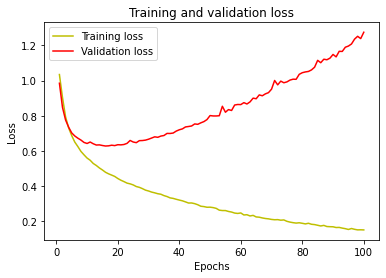

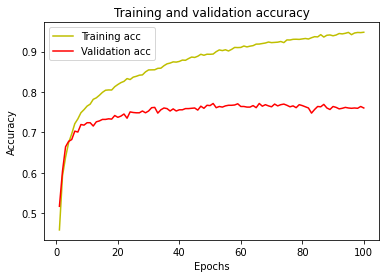

In [114]:
#ploting the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs,acc,'y',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [115]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Loss:",np.round(test_loss,4))
print("Test Accuracy:", np.round(test_accuracy,4))

53/53 [==============================] - 0s 6ms/step - loss: 1.2807 - accuracy: 0.7504
Test Loss: 1.2807
Test Accuracy: 0.7504


In [116]:
# Model Prediction
predictions = model.predict(test_data)

In [117]:
predicted_labels = np.argmax(predictions, axis=1)

In [118]:
# Calculating precision, recall, f1-score, and support for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predicted_labels, average="macro")

print("Accuracy:",np.round(test_loss,4)*100,'%')
print("Precision:", np.round(precision,4))
print("Recall:", np.round(recall,4))
print("F1-score:", np.round(f1_score,4))

Accuracy: 128.07 %
Precision: 0.7458
Recall: 0.738
F1-score: 0.7415
